In [21]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
#Pre-run code
import os
import sys
import gc
os.listdir('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main/dust_model')
sys.path.append('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main')
sys.path.append('/mnt/c/Users/jdpul/OneDrive/Desktop/Galacticus-dust-modelling-main/dust_model')
import birth_clouds1

In [22]:
A05= h5py.File('LuminosityFuna0p5.hdf5', 'r')

In [23]:
A05v2= h5py.File('LuminosityFuna0p5y.hdf5', 'r')

In [4]:
#Define functions that give Luminosity, Magnitude, and MergerTreeWeights. Plug data
#This def extracts the spheroid (name1) and disk (name2) Stellar luminosities from the Datasets above and adds them.
def L(name1, name2):
  return [x + y for x, y in zip(np.array(name1['Outputs/Output1/nodeData/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000']), np.array(name2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000']))]
#Name 1 is the Luminosity produced by L(name1, name2), while Name 2 is the general hdf5 file uploaded (i.e. V100)

def Lv2(name1, name2, name3, name4):
  return [x + y + z + w for x, y, z, w in zip(np.array(name1['Outputs/Output1/nodeData/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000']), np.array(name2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000']), np.array(name3['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young']), np.array(name4['Outputs/Output1/nodeData/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young']))]

Magnitude=np.arange(-24,-15,1)
def W(name1, name2):
   Table=pd.DataFrame({'Magnitude':name1, 'MergerTreeWeights':np.array(name2['Outputs/Output1/mergerTreeWeight'])}) 
   Table['binzz']=pd.cut(Table['Magnitude'], Magnitude)
   resultz=Table.groupby('binzz').agg(
       Sum=('MergerTreeWeights', 'sum')
   ).reset_index()
   return resultz

def M(name):
  for i in range(len(name)):
    if name[i]==0:    #Some Luminosities are 0 and log10(0)=Undefined when calculating Magnitudes
       name[i]=0.99999
  return -2.5*np.log10(name) 

wavelengths=np.geomspace(2875, 4375, num=1)

def fix(name):
    for i in range(len(name)):
        if np.isnan(name[i]) or name[i] == np.inf or name[i] < 1e-8:
            name[i] = 1e-8
    return name

def Rfix(name):
    for i in range (len(name)):
        if name[i] == 0:
           name[i]=1e-13
    return name
    
Magnitudes=np.arange(-24,-15,2)
Magnitude1=[-23.5, -22.5, -21.5, -20.5, -19.5, -18.5, -17.5, -16.5]

In [5]:
A05L=L(A05, A05)
A05M=M(A05L)
A05W=W(A05M, A05)

/tmp/ipykernel_65358/2631725876.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultz=Table.groupby('binzz').agg(


In [6]:
A05v2L=L(A05v2, A05v2)
A05v2M=M(A05v2L)
A05v2W=W(A05v2M, A05v2)

/tmp/ipykernel_65358/2631725876.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultz=Table.groupby('binzz').agg(


In [7]:
A05v3L=Lv2(A05v2, A05v2, A05v2, A05v2)
A05v3M=M(A05v3L)
A05v3W=W(A05v3M, A05v2)

/tmp/ipykernel_65358/2631725876.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resultz=Table.groupby('binzz').agg(


Text(0, 0.5, 'Log($\\Phi$, $[{\\rm Mpc}^{-3}M_{UV}^{-1}]$)')

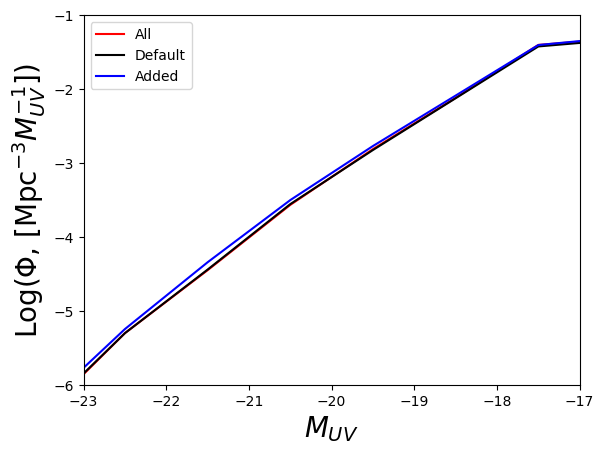

In [8]:
plt.plot(Magnitude1, np.log10(np.array(A05W['Sum'])), label=r'All', color='r')
plt.plot(Magnitude1, np.log10(np.array(A05v2W['Sum'])), label=r'Default', color='black')
plt.plot(Magnitude1, np.log10(np.array(A05v3W['Sum'])), label=r'Added', color='blue')
plt.legend()
plt.ylim([-6, -1])
plt.xlim([-23, -17])
plt.xlabel(r'$M_{UV}$', fontsize=20)
plt.ylabel(r"Log($\Phi$, $[{\rm Mpc}^{-3}M_{UV}^{-1}]$)", fontsize=20)

In [8]:
Z=(np.array(A05v2['Outputs/Output1/nodeData/diskAbundancesGasMetals'])/np.array(A05v2['Outputs/Output1/nodeData/diskMassGas']))

/tmp/ipykernel_66555/3788446661.py:1: RuntimeWarning: invalid value encountered in divide
  Z=(np.array(A05v2['Outputs/Output1/nodeData/diskAbundancesGasMetals'])/np.array(A05v2['Outputs/Output1/nodeData/diskMassGas']))


In [10]:
metallicities = fix(Z)

In [12]:
def spheroid_clouds_attenuation(metallicities, wavelengths, Tmax=5):
    As_cloud= []
    for Z in metallicities:
        clouds = birth_clouds.birth_clouds(
            Zcloud=Z,
            Tmax=Tmax * u.Gyr,
            SPS_bounds_error=False,
            extend_albedo_beyond_limit=True
        )
        Alambda = clouds.attenuation(wavelengths, Tbins=10)
        As_cloud.append(Alambda)

    return As_cloud

def disk_clouds_attenuation(metallicities, wavelengths, Tmax=5):
    Ad_cloud= []
    for Z in metallicities:
        clouds = birth_clouds.birth_clouds(
            Zcloud=Z,
            Tmax=Tmax * u.Gyr,
            SPS_bounds_error=False,
            extend_albedo_beyond_limit=True
        )
        Alambda = clouds.attenuation(wavelengths, Tbins=10)
        Ad_cloud.append(Alambda)

    return Ad_cloud

In [ ]:
As=spheroid_clouds_attenuation(metallicities, wavelengths, Tmax=5)

In [ ]:
L_attyd=np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young'])*Ad_mean_cloud
L_attys=np.array(A05v2['Outputs/Output1/nodeData/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young'])*As_mean_cloud
L_unatt=np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])+np.array(A05v2['Outputs/Output1/nodeData/spheroidLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])
L_att=L_attyd+L_attys+L_unatt

In [ ]:
M_att=M(L_att)
M_attW=W(M_att, A05v2)

array([2875.        , 3012.29757499, 3156.15188879, 3306.87606292,
       3464.79817221, 3630.26195895, 3803.62758104, 3985.27239601,
       4175.59178231, 4375.        ])

In [13]:
Eta=np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young'])/np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])

/tmp/ipykernel_66555/1243107058.py:1: RuntimeWarning: invalid value encountered in divide
  Eta=np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000:young'])/np.array(A05v2['Outputs/Output1/nodeData/diskLuminositiesStellar:JWST_NIRCAM_f277w:observed:z8.0000'])


In [20]:
print(Z)

[ 4.09195765e-02  4.14614811e-02  3.96909788e-02  3.86429227e-02
  4.03334264e-02  3.92529990e-02  4.99723203e-02  4.01726531e-02
  4.64528958e-02  5.44479647e-04  2.40077698e-02  4.40940286e-02
  3.98346184e-02  4.67414959e-02  5.00544605e-02  5.72860242e-02
  9.79285136e-02  3.43332576e-02 -9.82079518e-02  5.57581622e-02
  4.17868572e-02  6.06502506e-02  4.02925493e-02  5.18421720e-02
  3.85822172e-02  2.92035495e-02  4.85290327e-02  4.10435660e-02
  4.21142069e-02  4.24042786e-02             nan             nan
  4.14480899e-02  3.35041324e-02  5.88044976e-02  4.28916007e-02
  4.17364479e-02  3.13247731e-02  4.76015788e-02  4.09828217e-02
  6.40600311e-02  3.04838938e-02  4.11136888e-02  6.00802102e-02
  3.80198420e-02  4.17029021e-02  4.34892533e-02  4.59570938e-02
  4.48583132e-02  4.48309967e-02  3.92344422e-02  4.19595916e-02
  3.88465489e-02  4.93174749e-02  4.09024820e-02  4.43559399e-02
  4.43983117e-02  2.91365691e-01  4.21771513e-02 -3.76922876e-02
  5.84999801e-02  3.86049

In [19]:
np.set_printoptions(threshold=4000)